In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import pytz
from matplotlib.dates import DateFormatter
matplotlib.rcParams['timezone'] = 'US/Eastern'

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alex/nyt-2020-election-scraper/master/battleground-state-changes.csv")

In [3]:
eastern = pytz.timezone('US/Eastern')
df.index = pd.to_datetime(df['timestamp'])
df.index = df.index.tz_localize(pytz.utc).tz_convert(eastern)
pa = df[df["state"].str.startswith("Penn")].vote_differential
ga = df[df["state"].str.startswith("Georgia")].vote_differential
az = df[df["state"].str.startswith("Arizona")].vote_differential

In [4]:
def deficit_plot(df, label="", ax=None):
    if not ax:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    df[df.index > "2020-11-05"].plot(ax=ax, label=label)
    ax.set_ylim(min(0, min(df)))
    ax.set_ylabel("Deficit")
    ax.set_xlabel("Time (Eastern)")
    ax.get_figure().set_facecolor("white")
    date_form = DateFormatter("%m-%d %I%p")
    ax.xaxis.set_major_formatter(date_form)
    ax.legend();
    ax.grid(axis='y')

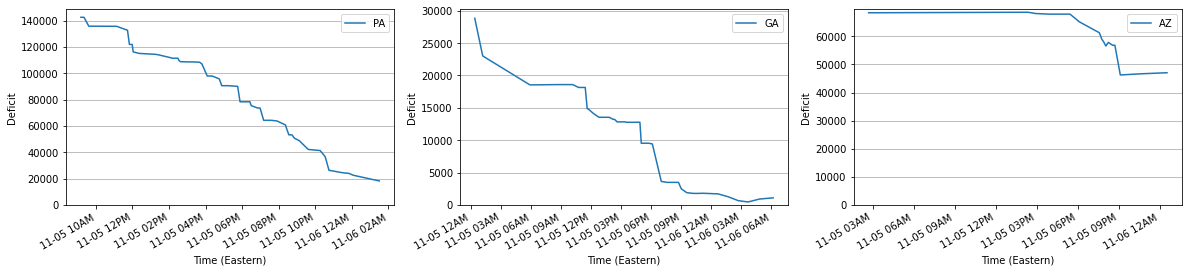

In [5]:
fig, axs = plt.subplots(1,3, figsize=(20,4))
deficit_plot(pa, "PA", axs[0])
deficit_plot(ga, "GA", axs[1])
deficit_plot(az, "AZ", axs[2])
fig.savefig("plot1.png", bbox_inches="tight")

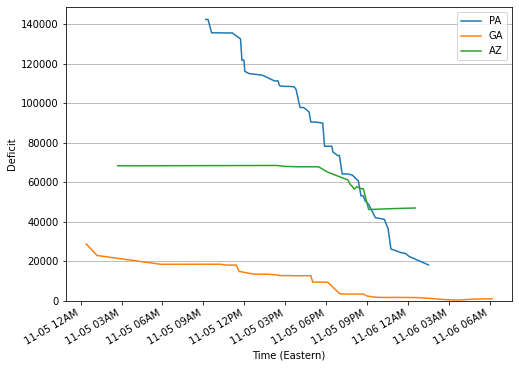

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
deficit_plot(pa, "PA", ax)
deficit_plot(ga, "GA", ax)
deficit_plot(az, "AZ", ax)
fig.savefig("plot2.png", bbox_inches="tight")